In [2]:

import pprint
import sys
from heapq import heapify, heappop, heappush, heapreplace, nlargest, nsmallest
from math import log2
from operator import itemgetter
from random import random
import numpy as np
import matplotlib.pyplot as plt

import h5py
import time
import pickle

from hnsw import HNSW


In [3]:

f = h5py.File('module/openai_embedding_output.hdf5','r')
distances = f['distances']
neighbors = f['neighbors']
test = f['test']
train = f['train']


In [21]:

hnsw = HNSW("cosine", m=5, ef=10)

insert_times = []
for i, vec in enumerate(train[:]):
    hnsw.add(vec)


### HNSW 인덱스 동작 과정

In [22]:
def debug_search_graph(hnsw, q, ep, layer, ef):
    """_search_graph() 함수의 동작을 단계별로 출력하며 힙과 검색 결과의 상태를 명확히 설명합니다."""
    vectorized_distance = hnsw.vectorized_distance
    data = hnsw.data

    # 초기 힙 설정 및 방문한 노드 추적
    candidates = [(-mdist, p) for mdist, p in ep]
    heapify(candidates)  # 탐색 후보를 힙으로 변환
    visited = set(p for _, p in ep)  # 방문한 노드 집합

    print(f"\n[INFO] 탐색 시작 - 초기 탐색 후보(candidates): {candidates}")
    print(f"[INFO] 초기 검색 결과(ep): {[(-d, p) for d, p in ep]}")
    print(f"[INFO] 초기 방문 노드: {visited}")

    # 탐색 시작
    while candidates:


        # 1. 힙에서 가장 가까운 노드 꺼냄
        dist, current_node = heappop(candidates)
        print(f"\n[INFO] [탐색 후보에서 POP] 노드 {current_node} 꺼냄 (거리: {dist:.4f})")

        # 검색 결과의 최대 거리와 비교해 탐색 종료 여부 결정
        mref = ep[0][0]  # 검색 결과 중 가장 먼 노드의 거리
        if dist > -mref:
            print(f"[INFO] [탐색 종료] {dist:.4f} > {-mref:.4f} (검색 결과 중 최대 거리보다 멂)")
            break

        # 2. 현재 노드의 이웃 탐색
        neighbors = [n for n in layer[current_node] if n not in visited]
        visited.update(neighbors)
        print(f"[INFO] [이웃 탐색] 노드 {current_node}의 이웃: {neighbors}\n")

        print("=" * 50 + "\n")

        # 3. 쿼리와 이웃 노드 간 거리 계산
        distances = vectorized_distance(q, [data[n] for n in neighbors])
        neighbor_count = len(neighbors)
        cnt = 1

        # 4. 힙과 검색 결과 업데이트
        for neighbor, dist in zip(neighbors, distances):
            print(f"[INFO] 현재 이웃 노드({cnt}/{neighbor_count}) : {neighbor} (거리: {dist:.4f})")
            cnt += 1
            

            dist = np.round(dist, 4)
            mdist = -dist  # 최소 힙을 위해 음수 변환

            if len(ep) < ef:
                print(f"[INFO] 검색 결과: {[(-d, p) for d, p in ep]}")
                heappush(candidates, (dist, neighbor))
                heappush(ep, (mdist, neighbor))
                print(f"[INFO] => ✅ 검색 결과 업데이트: 노드 {neighbor} 추가 (거리: {dist:.4f})")
                print()
            elif mdist > ep[0][0]:

                print(f"[INFO] 검색 결과: {[(-d, p) for d, p in ep]}")
                print(
                    f"[INFO] => ✅ 검색 결과 업데이트: 노드 {neighbor}가 "
                    f"검색 결과의 최대 거리 ({-ep[0][0]:.4f})보다 가까워서 "
                    f"{ep[0][1]}번 노드와 교체됨\n "
                )
                heappush(candidates, (dist, neighbor))
                heapreplace(ep, (mdist, neighbor))

            else:
                print(f"[INFO] 검색 결과: {[(-d, p) for d, p in ep]}")
                print(f"[INFO] => ❌ 노드 {neighbor} 무시 (거리가 검색 결과 중 최대 거리보다 멂)\n")

        print("=" * 50 + "\n")

        # 현재 탐색 후보와 검색 결과 상태 출력
        print(f"[INFO] [현재 탐색 후보(candidates)] {candidates}")
        print(f"[INFO] [현재 검색 결과(ep)] {[(-np.round(d, 4), p) for d, p in ep]}")

    print("[INFO] 탐색 완료")


In [23]:
debug_search_graph(hnsw, test[0], [(-hnsw.distance(test[0], hnsw.data[hnsw._enter_point]), hnsw._enter_point)], hnsw._graphs[0], 3)


[INFO] 탐색 시작 - 초기 탐색 후보(candidates): [(0.2638688087463379, 553)]
[INFO] 초기 검색 결과(ep): [(0.2638688087463379, 553)]
[INFO] 초기 방문 노드: {553}

[INFO] [탐색 후보에서 POP] 노드 553 꺼냄 (거리: 0.2639)
[INFO] [이웃 탐색] 노드 553의 이웃: [247, 80, 416, 218, 172, 42, 441, 297, 617, 808]


[INFO] 현재 이웃 노드(1/10) : 247 (거리: 0.2794)
[INFO] 검색 결과: [(0.2638688087463379, 553)]
[INFO] => ✅ 검색 결과 업데이트: 노드 247 추가 (거리: 0.2794)

[INFO] 현재 이웃 노드(2/10) : 80 (거리: 0.2864)
[INFO] 검색 결과: [(0.2794, 247), (0.2638688087463379, 553)]
[INFO] => ✅ 검색 결과 업데이트: 노드 80 추가 (거리: 0.2864)

[INFO] 현재 이웃 노드(3/10) : 416 (거리: 0.2896)
[INFO] 검색 결과: [(0.2864, 80), (0.2638688087463379, 553), (0.2794, 247)]
[INFO] => ❌ 노드 416 무시 (거리가 검색 결과 중 최대 거리보다 멂)

[INFO] 현재 이웃 노드(4/10) : 218 (거리: 0.2874)
[INFO] 검색 결과: [(0.2864, 80), (0.2638688087463379, 553), (0.2794, 247)]
[INFO] => ❌ 노드 218 무시 (거리가 검색 결과 중 최대 거리보다 멂)

[INFO] 현재 이웃 노드(5/10) : 172 (거리: 0.2772)
[INFO] 검색 결과: [(0.2864, 80), (0.2638688087463379, 553), (0.2794, 247)]
[INFO] => ✅ 검색 결과 업데이트: 노드 172가 검색

In [24]:
def debug_add(hnsw, elem):
    
    # 1. 삽입할 레벨 결정
    level = int(-log2(random()) * hnsw._level_mult) + 1
    print(f"\n[INFO] 벡터의 삽입 레벨 결정: {level-1}")

    idx = len(hnsw.data)  # 현재 벡터 인덱스
    hnsw.data.append(elem)
    print(f"[INFO] 벡터 인덱스: {idx}")

    if hnsw._enter_point is None:
        # 첫 번째 노드일 경우 처리
        print("[INFO] 첫 번째 노드로 삽입됨.")
        hnsw._enter_point = idx
    else:
        point = hnsw._enter_point
        # 2. 엔트리 포인트로부터 가장 가까운 노드 탐색
        dist = hnsw.distance(elem, hnsw.data[point])

        # 상위 레벨부터 가장 가까운 노드 탐색
        curr_lev = len(hnsw._graphs) - 1
        for layer in reversed((hnsw._graphs[level:])):
            point, dist = hnsw._search_graph_ef1(elem, point, dist, layer)
            print(f"[INFO] 레벨 {curr_lev} 검색 결과 - 노드: {point}, 거리: {dist:.4f}")
            curr_lev -= 1

        # 3. 각 레벨에 노드 추가 및 이웃 업데이트
        ep = [(-dist, point)]
        layer0 = hnsw._graphs[0]  # 최하위 레벨

        for layer in reversed(hnsw._graphs[:level]):
            level_m = hnsw._m if layer is not layer0 else hnsw._m0

            # 레벨에서 이웃 노드 탐색 및 업데이트
            ep = hnsw._search_graph(elem, ep, layer, hnsw._ef)
            print(f"[INFO] 레벨 {curr_lev} 검색 결과: {[(-np.round(d, 4), p) for d, p in ep]}")
            layer[idx] = layer_idx = {}
            hnsw._select(layer_idx, ep, level_m, layer, heap=True)

            print(f"[INFO] 레벨 {curr_lev}에 노드 {idx} 추가 완료")
            curr_lev -= 1

            # 역방향 링크 설정 (backlink)
            for neighbor_idx, dist in layer_idx.items():
                hnsw._select(layer[neighbor_idx], (idx, dist), level_m, layer)

    # 새로 생성된 레벨이 있을 경우 처리
    for i in range(len(hnsw._graphs), level):
        hnsw._graphs.append({idx: {}})
        print(f"[INFO] [레벨 생성] 새로운 레벨 {i} 생성 및 노드 추가 완료")



In [25]:
for i in range(10):
    debug_add(hnsw, test[i])


[INFO] 벡터의 삽입 레벨 결정: 0
[INFO] 벡터 인덱스: 900
[INFO] 레벨 4 검색 결과 - 노드: 553, 거리: 0.2639
[INFO] 레벨 3 검색 결과 - 노드: 553, 거리: 0.2639
[INFO] 레벨 2 검색 결과 - 노드: 230, 거리: 0.2199
[INFO] 레벨 1 검색 결과 - 노드: 350, 거리: 0.2146
[INFO] 레벨 0 검색 결과: [(0.219, 387), (0.2146, 350), (0.2119, 35), (0.2073, 628), (0.2105, 739), (0.1976, 270), (0.2024, 498), (0.1802, 791), (0.182, 199), (0.2057, 320)]
[INFO] 레벨 0에 노드 900 추가 완료

[INFO] 벡터의 삽입 레벨 결정: 1
[INFO] 벡터 인덱스: 901
[INFO] 레벨 4 검색 결과 - 노드: 553, 거리: 0.3487
[INFO] 레벨 3 검색 결과 - 노드: 296, 거리: 0.2460
[INFO] 레벨 2 검색 결과 - 노드: 296, 거리: 0.2460
[INFO] 레벨 1 검색 결과: [(0.2709, 839), (0.26, 352), (0.2652, 513), (0.2578, 652), (0.2562, 589), (0.261, 141), (0.2557, 703), (0.246, 296), (0.2557, 361), (0.2291, 598)]
[INFO] 레벨 1에 노드 901 추가 완료
[INFO] 레벨 0 검색 결과: [(0.2166, 546), (0.2145, 747), (0.2072, 181), (0.1853, 499), (0.2083, 489), (0.2048, 212), (0.1879, 101), (0.1804, 434), (0.1786, 8), (0.1882, 157)]
[INFO] 레벨 0에 노드 901 추가 완료

[INFO] 벡터의 삽입 레벨 결정: 0
[INFO] 벡터 인덱스: 902
[INFO] 레벨 4 

In [26]:
## level 분포
level_counts = [len(graph) for graph in hnsw._graphs]
print(f"level_counts: {level_counts}")

level_counts: [910, 174, 39, 11, 1]


In [27]:
def debug_search(hnsw, q, k=5, ef=50):
    """쿼리 벡터를 이용한 탐색 과정을 디버깅합니다."""
    point = hnsw._enter_point
    print(f"\n[INFO] 탐색 시작 - 엔트리 포인트: {point}")

    dist = hnsw.distance(q, hnsw.data[point])
    print(f"[INFO] 쿼리와 엔트리 포인트 간 거리: {dist:.4f}")

    # 1. 최상위 레벨부터 탐색
    for curr_lev in reversed(range(1, len(hnsw._graphs))):
        point, dist = hnsw._search_graph_ef1(q, point, dist, hnsw._graphs[curr_lev])
        print(f"[INFO] 레벨 {curr_lev} 검색 결과 - 노드: {point}, 거리: {dist:.4f}")

    # 2. 최하위 레벨에서 탐색 및 후보군 관리
    ep = hnsw._search_graph(q, [(-dist, point)], hnsw._graphs[0], ef)

    # 3. 최종 검색 결과 추출 (Top-K)
    ep = nlargest(k, ep)
    print(f"[INFO] 최종 검색 결과 (Top-{k}): {[(idx, -md) for md, idx in ep]}")


In [28]:
# 쿼리 탐색 테스트
debug_search(hnsw, test[0], k=5, ef=50)


[INFO] 탐색 시작 - 엔트리 포인트: 553
[INFO] 쿼리와 엔트리 포인트 간 거리: 0.2639
[INFO] 레벨 4 검색 결과 - 노드: 553, 거리: 0.2639
[INFO] 레벨 3 검색 결과 - 노드: 553, 거리: 0.2639
[INFO] 레벨 2 검색 결과 - 노드: 230, 거리: 0.2199
[INFO] 레벨 1 검색 결과 - 노드: 350, 거리: 0.2146
[INFO] 최종 검색 결과 (Top-5): [(900, 0.0), (791, 0.18023627996444702), (199, 0.18199849128723145), (270, 0.19761407375335693), (498, 0.20239180326461792)]


### HNSW 인덱스 특성

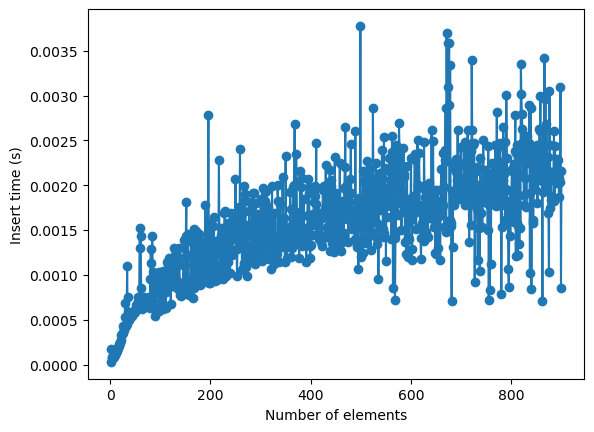

In [29]:
# 삽입 시간 측정
hnsw = HNSW("cosine", m=10, ef=20)

insert_times = []
for i, vec in enumerate(train[:]):
    start = time.time()
    hnsw.add(vec)
    insert_times.append(time.time() - start)

# 삽입 시간 그래프 시각화
plt.plot(range(1, 901), insert_times, marker='o')
plt.xlabel('Number of elements')
plt.ylabel('Insert time (s)')
plt.show()

In [30]:
# ef_search 변화에 따른 검색 시간 및 정확도 측정
ef_values = [10, 20, 30, 40, 50, 100]
search_times = []
accuracy_list = []

for ef in ef_values:
    start = time.time()
    correct = 0
    for i, q in enumerate(test[:]):
        search_k = 10
        pred_neighbors = [idx for idx, _ in hnsw.search(q, k=search_k, ef=ef)]

        actual_neighbors = neighbors[i][:search_k]
        correct += len(set(actual_neighbors) & set(pred_neighbors))

    accuracy_list.append(correct / (len(test) * 10))
    search_times.append(time.time() - start)


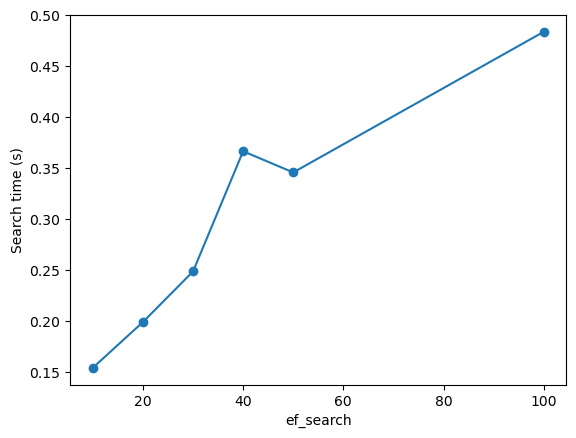

In [31]:
# ef_search에 따른 검색 시간 변화 

plt.plot(ef_values, search_times, marker='o')
plt.xlabel('ef_search')
plt.ylabel('Search time (s)')
plt.show()

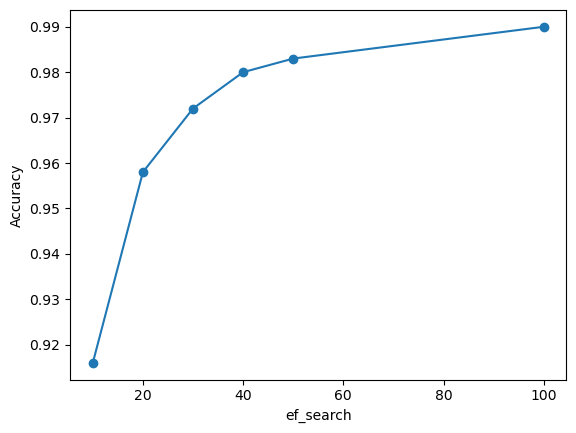

In [32]:
# ef_search에 따른 정확도 변화

plt.plot(ef_values, accuracy_list, marker='o')
plt.xlabel('ef_search')
plt.ylabel('Accuracy')
plt.show()